# Extracting color from VFX images
We want to test the LLMs capacity to extract the ability type from the video, and we want to be able to verify this. One idea here is that the colors and brightnesses for different elemental types are given in the League VFX design manual, therefore using OpenCV and some operations we may be able to quickly verify which is the most fitting class. 

In [235]:
import pathlib
import cv2
import numpy as np

frames_path = pathlib.Path("Data/Frames")

In [311]:
import json
from PIL import ImageColor

HUE_PALETTES = json.load(open("Schemas/spell_types.json"))['vfx_characteristics']['elemental_type']
HUE_PALETTES = {k: v['color_palette'].split(",") for k, v in HUE_PALETTES.items()}
for palette in HUE_PALETTES.values():
    for i, color in enumerate(palette):
        rgb = ImageColor.getrgb(color.strip())
        rgb_array = np.array([[rgb]], dtype=np.uint8)
        hsv = cv2.cvtColor(rgb_array, cv2.COLOR_RGB2HSV)
        palette[i] = {'H': hsv[0, 0, 0].item(), 'RGB': rgb}

LUMINANCE = ["#e8e8e8", "#b1b1b1", "#545454"]
for i, luminance in enumerate(LUMINANCE):
    LUMINANCE[i] = ImageColor.getcolor(luminance, "L")

LUMINANCE, HUE_PALETTES

([232, 177, 84],
 {'hextech': [{'H': 141, 'RGB': (165, 32, 224)},
   {'H': 129, 'RGB': (218, 202, 255)},
   {'H': 149, 'RGB': (254, 230, 255)},
   {'H': 90, 'RGB': (223, 255, 255)},
   {'H': 110, 'RGB': (8, 79, 229)},
   {'H': 90, 'RGB': (122, 255, 255)}],
  'wind': [{'H': 88, 'RGB': (157, 183, 181)},
   {'H': 88, 'RGB': (78, 201, 192)},
   {'H': 99, 'RGB': (50, 131, 164)},
   {'H': 87, 'RGB': (192, 254, 248)},
   {'H': 33, 'RGB': (44, 45, 33)}],
  'water': [{'H': 103, 'RGB': (43, 100, 145)},
   {'H': 106, 'RGB': (29, 73, 124)},
   {'H': 103, 'RGB': (14, 41, 62)},
   {'H': 103, 'RGB': (82, 176, 247)},
   {'H': 93, 'RGB': (195, 250, 255)}],
  'frost': [{'H': 94, 'RGB': (105, 217, 235)},
   {'H': 110, 'RGB': (32, 99, 237)},
   {'H': 119, 'RGB': (0, 8, 177)},
   {'H': 90, 'RGB': (161, 254, 254)}],
  'gun_powder': [{'H': 23, 'RGB': (248, 198, 23)},
   {'H': 5, 'RGB': (187, 47, 18)},
   {'H': 12, 'RGB': (105, 64, 35)},
   {'H': 30, 'RGB': (238, 239, 11)}],
  'arcane': [{'H': 111, 'RGB': (53

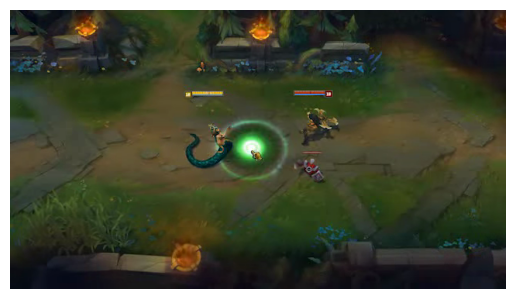

In [344]:
from matplotlib import pyplot as plt

image = cv2.imread(frames_path / "Cassiopeia_Q0016.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb); plt.axis('off'); plt.show();

In [296]:
# grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# brightest_vfx_mask = grayscale > LUMINANCE[0]
# medium_brightness_vfx_mask = grayscale > LUMINANCE[1]
# low_brightness_vfx_mask = grayscale > LUMINANCE[2]
# 
# vfx_masked_bright = grayscale.copy()
# vfx_masked_medium = grayscale.copy()
# vfx_masked_low = grayscale.copy()
# 
# vfx_masked_bright[~brightest_vfx_mask] = 0
# vfx_masked_medium[~medium_brightness_vfx_mask] = 0
# vfx_masked_low[~low_brightness_vfx_mask] = 0

In [254]:
# plt.imshow(vfx_masked_low, cmap="gray"); plt.axis('off'); plt.show()
# plt.imshow(vfx_masked_medium, cmap="gray"); plt.axis('off'); plt.show()
# plt.imshow(vfx_masked_bright, cmap="gray"); plt.axis('off'); plt.show()

In [333]:
# percent_hue_match = {}
# rgb_leniency = 40
# 
# grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# brightness_mask = grayscale > LUMINANCE[1]
# 
# for name, palette in HUE_PALETTES.items():
#     color_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=bool)
#     for color in palette:
#         rgb = color['RGB']
#         mod_diff = abs(rgb - image_rgb)
#         color_mask |= np.all(mod_diff <= rgb_leniency, axis=-1)
#     
#     vfx_masked = image_rgb.copy()
#     vfx_masked[~color_mask] = 0
#     vfx_masked[~brightness_mask] = 0
#     percent_hue_match[name] = np.count_nonzero(vfx_masked) / vfx_masked.size * 100
#     plt.imshow(vfx_masked); plt.title(name); plt.axis('off'); plt.show()
# percent_hue_match

In [352]:
from typing import Literal


def get_percent_rgb_match_by_spell_type(image, leniency=40, brightness_mask: Literal['bright', 'medium', 'low']='medium'):
    percent_hue_match = {}
    
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if brightness_mask == 'bright':
        brightness_mask = grayscale > LUMINANCE[0]
    elif brightness_mask == 'medium':
        brightness_mask = grayscale > LUMINANCE[1]
    elif brightness_mask == 'low':
        brightness_mask = grayscale > LUMINANCE[2]
    
    for name, palette in HUE_PALETTES.items():
        color_mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)
        for color in palette:
            rgb = color['RGB']
            mod_diff = abs(rgb - image)
            color_mask |= np.all(mod_diff <= leniency, axis=-1)
        
        vfx_masked = image.copy()
        vfx_masked[~color_mask] = 0
        vfx_masked[~brightness_mask] = 0
        percent_hue_match[name] = np.count_nonzero(vfx_masked) / vfx_masked.size * 100
    return percent_hue_match


def get_percent_hue_match_by_spell_type(image, leniency=30):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image_h = image_hsv[:, :, 0].astype(np.int16)
    percent_hue_match = {}
    
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness_mask = grayscale > LUMINANCE[2]
    
    for name, palette in HUE_PALETTES.items():

        color_mask = np.zeros_like(image_h, dtype=bool)
        for color in palette:
            hue = color['H']
            # Because of circular wrap around hue 179 is both very close to h = 0, h = 178
            mod_diff = np.minimum(abs(hue - image_h), 179 - abs(hue - image_h))
            color_mask |= mod_diff <= leniency
    
        vfx_masked = image.copy()
        vfx_masked[~color_mask] = 0
        vfx_masked[~brightness_mask] = 0
        percent_hue_match[name] = np.count_nonzero(vfx_masked) / vfx_masked.size * 100
        
    return percent_hue_match

get_percent_hue_match_by_spell_type(image_rgb), get_percent_rgb_match_by_spell_type(image_rgb, brightness_mask='low')

({'hextech': 5.15392641694725,
  'wind': 5.998176206509539,
  'water': 5.006751543209877,
  'frost': 5.108550785634119,
  'gun_powder': 1.0356165824915826,
  'arcane': 5.133803310886644,
  'nature': 2.3041614057239057,
  'celestial': 1.0629734848484849,
  'shadow_isle': 6.035528900112234,
  'poison': 3.0881734006734005,
  'void': 3.6838874859708195,
  'heal': 2.4668560606060606},
 {'hextech': 0.3918087121212121,
  'wind': 1.448074494949495,
  'water': 1.7011696829405163,
  'frost': 0.556344696969697,
  'gun_powder': 0.31942690796857465,
  'arcane': 0.9937920875420876,
  'nature': 0.09035669191919192,
  'celestial': 0.19426031144781145,
  'shadow_isle': 0.10206228956228956,
  'poison': 0.011135662177328844,
  'void': 0.0005260942760942761,
  'heal': 0.05616056397306397})

In [357]:
%%capture
import ffmpeg
filename = "Diana_Q.webm"

videos_path = pathlib.Path("Data/Videos")

output_pattern = f"Data/Frames/{filename.replace('.webm', '')}%04d.png"

ffmpeg.input(videos_path / filename).output(output_pattern, vf='fps=5').run()

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1732155217949/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1732155217949/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --e

In [358]:
import os

ability = "Diana_Q"

for file in sorted(os.listdir(frames_path)):
    if file.startswith(ability):
        image = cv2.imread(frames_path / file)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        percent_match = get_percent_rgb_match_by_spell_type(image_rgb)
        spell_type = max(percent_match, key=percent_match.get)
        if percent_match[spell_type] > 0.2:
            print(file, spell_type, percent_match[spell_type])

Diana_Q0006.png hextech 1.369554924242424
